In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader,random_split
import matplotlib.pyplot as plt
import datetime
import copy

In [2]:
#!pip install lightning > /dev/null 2>&1
#!pip install comet-ml >/dev/null 2>&1

In [ ]:
kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

In [3]:
import lightning as L
import comet_ml
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger,CometLogger
from lightning.pytorch.callbacks import ModelCheckpoint,Callback

/home/user/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [4]:
comet_ml.init(project_name="music-classification")
seed_everything(9797, workers=True)
batch_size=32
num_workers=0
data_path="./archive/Data/images_original"

COMET INFO: Comet API key is valid
Global seed set to 9797


In [5]:
class CustomDataset(Dataset):
    def __init__(self,subset,transform=None):
        self.subset=subset
        self.transform=transform
    def __getitem__(self,idx):
        x,y=self.subset[idx]
        if self.transform:
            x=self.transform(x)
        return x,y
    def __len__(self):
        return len(self.subset)

In [6]:
data_transforms = {
     'train':  transforms.Compose([ transforms.TrivialAugmentWide(),
                                   transforms.CenterCrop(224),transforms.ToTensor(),
                                   transforms.Normalize([0., 0., 0.], [1., 1., 1.])]),
  
    'val': transforms.Compose([transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0., 0., 0.], [1., 1., 1.])
    ])
}

In [7]:
dataset=torchvision.datasets.ImageFolder(data_path)

use_data_module=False
if not use_data_module:
    train_d,valid_d=random_split(dataset,lengths=[0.8,0.2])

In [8]:


if not use_data_module:
    datasets={'train':train_d,'val':valid_d}
    image_datasets = {x: CustomDataset(datasets[x],data_transforms[x])
                  for x in ['train', 'val']}

            
            

In [9]:
if not use_data_module:
    dataloaders={}
    dataloaders['train'] = DataLoader(image_datasets['train'], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
    dataloaders['val'] = DataLoader(image_datasets['train'], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


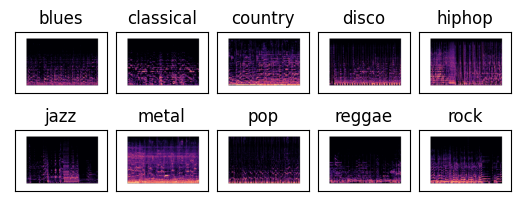

In [10]:
class_names=dataset.classes
print(class_names)
fig=plt.figure()
fig.tight_layout()
plt.subplots_adjust( wspace=.1, hspace=.3)
for i in range(10):
            #img,label=next(itr)
            img,label=dataset[i*100]
            t=fig.add_subplot(4,5,i+1)
            # set the title of the image equal to its label
            t.set_title(class_names[label])
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(img)

In [11]:
class DataModule(L.LightningDataModule):
    def __init__(self,data_path="./",batch_size=64,num_workers=0,
                 transforms=None):
        super().__init__()
        self.batch_size=batch_size
        self.data_path=data_path
        self.num_workers=num_workers
        self.transforms=transforms
       ## Note that the difference between prepare_data and setup
        ## is that prepare_data is called only once
        ## whereas setup is called per device.
        ## So if we are using a single device there is no difference
    def setup(self,stage):
               
            return
    def prepare_data(self):
                #train_d,valid_d=random_split(dataset,lengths=[0.8,0.2])
                #self.datasets={'train':train_d,'val':valid_d}
                #self.image_datasets = {x: CustomDataset(self.datasets[x],self.transforms[x])
                #  for x in ['train', 'val']}
                return

    def train_dataloader(self):
        #return dataloaders['train']
                     return DataLoader(image_datasets['train'],
                            batch_size=self.batch_size,
                            shuffle=True,num_workers=self.num_workers)
    def val_dataloader(self):
        #return dataloaders['val']
                     return DataLoader(image_datasets['val'],
                            batch_size=self.batch_size,
                            shuffle=False,num_workers=self.num_workers)
    def test_dataloader(self):
                     return DataLoader(self.image_datasets['val'],
                            batch_size=self.batch_size,
                            shuffle=False,num_workers=self.num_workers)

In [12]:
class LResNet(L.LightningModule):
    def __init__(self,model,num_classes,lr=1e-3,momentum=0):
        super().__init__()
        self.model=model(num_classes=num_classes)
        self.lr=lr
        self.momentum=momentum
        self.num_classes=num_classes
        self.save_hyperparameters()
    def training_step(self,batch,batch_idx):
        x,y=batch
        y_hat=self.model(x)
        loss=nn.functional.cross_entropy(y_hat,y)
        acc=(y_hat.argmax(dim=1)==y).float().mean()
        self.log("train_loss",loss,prog_bar=True,on_epoch=True,on_step=False)
        self.log("train_acc",acc,prog_bar=True,on_epoch=True,on_step=False)
        return loss
    def validation_step(self,batch,batch_idx):
        x,y=batch
        y_hat=self.model(x)
        loss=nn.functional.cross_entropy(y_hat,y)
        acc=(y_hat.argmax(dim=1)==y).float().mean()
        self.log("val_loss",loss,prog_bar=True,on_epoch=True,on_step=False)
        self.log("val_acc",acc,prog_bar=True,on_epoch=True,on_step=False)
        return {'val_loss':loss,'val_acc':acc}
    def configure_optimizers(self):
        return optim.SGD(self.model.parameters(),
                        lr=self.lr,momentum=self.momentum)

In [13]:
class ResNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.resnet=models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc=nn.Linear(self.resnet.fc.in_features,num_classes)
    def forward(self,x):
        return self.resnet(x)

In [14]:
max_epochs=50
learning_rate=0.001
momentum=0.9
Lmodule=LResNet(ResNet,num_classes=10,lr=learning_rate,momentum=momentum)
comet_logger=CometLogger(experiment_name='music_classification')
csv_logger=CSVLogger(save_dir="logs",name="music")
trainer=L.Trainer(accelerator='gpu',devices=1,max_epochs=max_epochs,deterministic=True,
                 logger=[comet_logger,csv_logger],
                 callbacks=ModelCheckpoint(dirpath="./checkpoints",monitor="val_acc",
                    mode="max",save_top_k=3)
                 )


CometLogger will be initialized in online mode
/home/user/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
if use_data_module:
    data_module=DataModule(data_path=data_path,transforms=data_transforms,
                      batch_size=batch_size,num_workers=num_workers)
    trainer.fit(Lmodule,datamodule=data_module)

            
else:
    trainer.fit(Lmodule,train_dataloaders=dataloaders['train'],
           val_dataloaders=dataloaders['val'])


You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/user/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/user/Downloads/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
COMET WARNING: Comet has disabled auto-logging functionality as it has

Sanity Checking: 0it [00:00, ?it/s]

/home/user/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/user/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/user/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_st

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hikmat-farhat-gmail-com/music-classification/5ea0fb26c5764e5d9fe732ef9ec2bcbb
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_acc [50]  : (0.20624999701976776, 0.9412500262260437)
COMET INFO:     train_loss [50] : (0.19160661101341248, 2.220242500305176)
COMET INFO:     val_acc [50]    : (0.36625000834465027, 0.9612500071525574)
COMET INFO:     val_loss [50]   : (0.15224285423755646, 1.9162052869796753)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : music_classification
COMET INFO:   Parameters:
COMET INFO:     

In [16]:
comet_logger.experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hikmat-farhat-gmail-com/music-classification/5ea0fb26c5764e5d9fe732ef9ec2bcbb

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/hikmat-farhat-gmail-com/music-classification/5ea0fb26c5764e5d9fe732ef9ec2bc

Hybrid Approach